In [1]:
include("TDCM_modelling.jl")

In [24]:
using RCall

R"""
load("TDCM_Multilevel_data2.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group);

In [25]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features) .* 10
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [3.0]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [3.0]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

In [26]:
function update_categorical_variational_distribution_t1(
    model               :: TDCModel;
    step                :: T = 1e-2,
    tol                 :: T = 1e-6,
    maxiter             :: Int = 100000,
    verbose             :: Bool = true
) where T <: AbstractFloat
    obs = model.obs
    Y, D, X = obs.Y, obs.D, obs.X
    Z_sample, beta_sample, gamma_sample = model.Z_sample, model.beta_sample, model.gamma_sample
    pi_star_old = model.pi_star
    # Number of students, time points, questions, skills, attribute profiles, groups
    N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)
    M = model.M
    # Fully update parameters of each Z_i using noisy gradients before moving to update parameters of next Z_i
    if !model.enable_parallel
        @inbounds for i in 1:N
            # Storage for gradient terms
            grad_log_q = model.storage_L2
            grad_L = model.storage_L3
            # Storage for intermediate term in gradient calculations
            D_beta = model.storage_L
            rho_star_old_i = view(model.storage_LL3, 1:L)
            # Get parameters for variational distribution of skill of i-th student
            pi_star_old_i = pi_star_old[i][1]
            # Get group number of student i
            group_i = obs.group[i]
            # Perform gradient descent update of i-th π*    
            @inbounds for iter in 1:maxiter
                # Rho is unique up to a constant addative term
                rho_star_old_i = log.(pi_star_old_i)
                # Sample Z with updated π*
                sample_Z(model, i, 1)
                # Set gradient of ELBO to 0
                fill!(grad_L, 0)
                # Rao Blackwellized ELBO
                ELBO = 0
                # Calculate the gradient estimate of the m-th sample
                @inbounds for m in 1:M
                    z_im = Z_sample[i][1][m]
                    # Calculate gradient of log(q_1i(Z_i)) w.r.t. π*_i
                    grad_log_q .= z_im .- pi_star_old_i
                    # Calculate log(p(Y, Z_(i)))
                    log_prob_YZ = 0
                    @inbounds for j in 1:J
                        mul!(D_beta, D[j], beta_sample[j][m])
                        log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
                    end
                    # Calculate log(q_1i(Z_i))
                    log_q = dot(z_im, log.(pi_star_old_i))
                    # Update average gradient
                    grad_L .= (m - 1)/m .* grad_L + 1/m .* grad_log_q .* (log_prob_YZ - log_q)
                    # Update ELBO estimator
                    ELBO = (m-1)/m * ELBO + 1/m * (log_prob_YZ - log_q)
                end
                # Print ELBO, parameter and gradient if verbose
                if verbose
                    println("ELBO: $ELBO")
                    println("π*_$i: $pi_star_old_i")
                    println("gradient: $grad_L")
                end
                # Update with one step
                rho_star_old_i .+= step * grad_L
                # Convert logits into probabilities
                pi_star_old_i .= exp.(rho_star_old_i) ./ sum(exp.(rho_star_old_i))
                # Stop condition
                if abs2(norm(grad_L)) <= tol
                    break
                end
            end
        end
    else
        Threads.@threads for i in 1:N
            # Get thread id
            tid = Threads.threadid()
            # Storage for gradient terms
            grad_log_q = model.storage_L2_par[tid]
            grad_L = model.storage_L3_par[tid]
            # Storage for intermediate term in gradient calculations
            D_beta = model.storage_L_par[tid]
            rho_star_old_i = view(model.storage_LL3_par[tid], 1:L)
            # Get parameters for variational distribution of skill of i-th student
            pi_star_old_i = pi_star_old[i][1]
            # Get group number of student i
            group_i = obs.group[i]
            # Perform gradient descent update of i-th π*    
            @inbounds for iter in 1:maxiter
                # Rho is unique up to a constant addative term
                rho_star_old_i = log.(pi_star_old_i)
                # Sample Z with updated π*
                sample_Z(model, i, 1)
                # Set gradient of ELBO to 0
                fill!(grad_L, 0)
                # Rao Blackwellized ELBO
                ELBO = 0
                # Calculate the gradient estimate of the m-th sample
                @inbounds for m in 1:M
                    z_im = Z_sample[i][1][m]
                    # Calculate gradient of log(q_1i(Z_i)) w.r.t. π*_i
                    grad_log_q .= z_im .- pi_star_old_i
                    # Calculate log(p(Y, Z_(i)))
                    log_prob_YZ = 0
                    for j in 1:J
                        mul!(D_beta, D[j], beta_sample[j][m])
                        log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
                    end
                    # Calculate log(q_1i(Z_i))
                    log_q = dot(z_im, log.(pi_star_old_i))
                    # Update average gradient
                    grad_L .= (m - 1)/m .* grad_L + 1/m .* grad_log_q .* (log_prob_YZ - log_q)
                    # Update ELBO estimator
                    ELBO = (m-1)/m * ELBO + 1/m * (log_prob_YZ - log_q)
                end
                # Print ELBO, parameter and gradient if verbose
                if verbose
                    println("ELBO: $ELBO")
                    println("π*_$i: $pi_star_old_i")
                    println("gradient: $grad_L")
                end
                # Update with one step
                rho_star_old_i .+= step * grad_L
                # Convert logits into probabilities
                pi_star_old_i .= exp.(rho_star_old_i) ./ sum(exp.(rho_star_old_i))
                # Stop condition
                if abs2(norm(grad_L)) <= tol
                    break
                end
            end
        end
    end
end

update_categorical_variational_distribution_t1 (generic function with 1 method)

In [27]:
function update_normal_variational_distribution_t1(
    model       :: TDCModel;
    init_step   :: T=1e-3,
    grad_clip   :: Bool=false,
    clip_val    :: T=10.0,
    step_iterator=get_robbins_monroe_iterator(init_step, 20),
    # step_iterator_factory=get_robbins_monroe_iterator,
    use_iter    :: Bool=false,
    tol         :: T=1e-6,
    maxiter     :: Int=100000,
    verbose     :: Bool=true
) where T <: AbstractFloat
    obs = model.obs
    Y, D = Array{T, 3}(obs.Y), Vector{Matrix{T}}(obs.D)
    Z_sample, beta_sample = model.Z_sample, model.beta_sample
    mu_star_old, V_star_old = model.mu_beta_star, model.V_beta_star
    N, J, L, O = size(Y, 1), size(Y, 3), size(D[1], 1), size(obs.Y, 2)
    M = model.M
    # Fully update parameters of each β_j using noisy gradients before moving to update parameters of next β_j
    if !model.enable_parallel
        @inbounds for j in 1:J
            mu_star_old_j = mu_star_old[j]
            V_star_old_j = V_star_old[j]
            # Perform gradient descent update of mu_j and V_j
            len_beta = length(beta_sample[j][1])
            # Assign storage for gradient terms
            # Memory assigned from preallocated storage
            # Memory has to be strided (equal stride between memory addresses) to work with BLAS and LAPACK 
            # (important for vectorized matricies to be strided if we want to use them for linear algebra)
            # Matricies are stored column major in Julia, so memory is assigned by column left to right
            grad_mu_L = view(model.storage_L, 1:len_beta)
            grad_C_L = view(model.storage_LL2, 1:len_beta, 1:len_beta)
            vech_grad_C_L = view(grad_C_L, [len_beta * (j - 1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as grad_C_L
            grad_mu_log_q = view(model.storage_L2, 1:len_beta)
            vec_grad_V_log_q = view(model.storage_LL3, 1:len_beta^2)
            grad_V_log_q = reshape(vec_grad_V_log_q, len_beta, len_beta) # Uses same memory as vec_grad_V_log_q
            # Assign storage for calculating intermediate terms for gradient
            Vinv_star_old_j = view(model.storage_LL, 1:len_beta, 1:len_beta)
            beta_minus_mu = view(model.storage_L3, 1:len_beta)
            L_beta_minus_mu = view(model.storage_L4, 1:len_beta)
            C_star_old_j = view(model.storage_C, 1:len_beta, 1:len_beta)
            vech_C_star_old_j = view(C_star_old_j, [len_beta * (j - 1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as C_star_old_j
            fill!(C_star_old_j, 0)
            storage_kron_prod = view(model.storage_L2L2, 1:len_beta^2, 1:len_beta^2)
            storage_len_beta_sqr = view(model.storage_Lsqr, 1:len_beta^2)
            storage_len_beta_sqr2 = view(model.storage_Lsqr2, 1:len_beta^2)
            storage_gradC = view(model.storage_gradC, 1:Int(len_beta * (len_beta + 1) / 2))
            # Generate commutation and duplication matrix
            comm_j = view(model.storage_comm, 1:len_beta^2, 1:len_beta^2)
            dup_j = view(model.storage_dup, 1:len_beta^2, 1:Int(len_beta * (len_beta + 1) / 2))
            get_comm!(comm_j, len_beta)
            get_dup!(dup_j, len_beta)
            # Assign len_beta by len_beta identity matrix
            I_j = view(model.I_LL, 1:len_beta, 1:len_beta)
            # # Get step size iterator
            # step_iterator = step_iterator_factory(init_step)
            for iter in 1:maxiter
                # Sample β from variational distribution
                sample_β(model, idx_question=j)
                fill!(grad_mu_L, 0)
                fill!(grad_C_L, 0)
                # Copy V* into storage
                copy!(Vinv_star_old_j, V_star_old_j)
                # Perform cholesky decomposition on V*
                # After this step, the lower triangle of Vinv_star_old_j will contain the lower triangular cholesky factor of V*
                LAPACK.potrf!('L', Vinv_star_old_j)
                # Calculate log|V_j| from diagonal of cholesky decomposition
                logdet_V_j = 0
                for b in 1:len_beta
                    logdet_V_j += 2 * log(Vinv_star_old_j[b, b])
                end
                # Copy lower triangular cholesky factor into preallocated storage
                for k in 1:len_beta
                    for l in 1:k
                        C_star_old_j[k, l] = Vinv_star_old_j[k, l]
                    end
                end
                # Perform in place matrix inverse on positive definite V* matrix to get V* inverse
                LAPACK.potri!('L', Vinv_star_old_j)
                LinearAlgebra.copytri!(Vinv_star_old_j, 'L')
                ELBO = 0
                # Calculate the gradient estimate of the m-th sample
                for m in 1:M
                    beta_jm = beta_sample[j][m]
                    fill!(grad_mu_log_q, 0)
                    # grad_mu_log_q = Vinv_star * β_jm
                    BLAS.gemv!('N', T(1), Vinv_star_old_j, beta_jm, T(1), grad_mu_log_q)
                    # grad_mu_log_q = Vinv_star_j * β_jm - Vinv_star_j * mu_star_j
                    BLAS.gemv!('N', T(-1), Vinv_star_old_j, mu_star_old_j, T(1), grad_mu_log_q)
                    # grad_V_log_q = -1/2(Vinv_star_j - Vinv_star_j * (β_jm - mu_star_j) * (β_jm - mu_star_j)^T * Vinv_star_j)
                    copy!(grad_V_log_q, Vinv_star_old_j)
                    BLAS.gemm!('N', 'T', T(1 / 2), grad_mu_log_q, grad_mu_log_q, T(-1 / 2), grad_V_log_q)
                    # storage_kron_prod = I ⊗ C_j
                    collect!(storage_kron_prod, kronecker(I_j, C_star_old_j))
                    # storage_len_beta_sqr = (I ⊗ C_j)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_beta_sqr, 0))
                    # storage_kron_prod = C_j ⊗ I
                    collect!(storage_kron_prod, kronecker(C_star_old_j, I_j))
                    # storage_len_beta_sqr2 = (C_j ⊗ I)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_beta_sqr2, 0))
                    # storage_len_beta_sqr2 = ((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), comm_j, storage_len_beta_sqr, T(1), storage_len_beta_sqr2)
                    # storage_gradC = D'((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), dup_j, storage_len_beta_sqr2, T(1), fill!(storage_gradC, 0))
                    # Calculate log(p(Y, β_(j)))
                    log_prob_Ybeta = 0
                    for i in 1:N
                        fill!(model.storage_L3, 0)
                        BLAS.gemv!('N', (2 * Y[i, 1, j] - 1), D[j], beta_jm, T(1), model.storage_L3)
                        log_prob_Ybeta += dot(Z_sample[i][1][m], log.(sigmoid.(model.storage_L3)))
                    end
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= model.mu_beta_prior[j]
                    mul!(L_beta_minus_mu, model.L_beta_prior[j], beta_minus_mu)
                    log_prob_Ybeta -= 1/2 * dot(L_beta_minus_mu, L_beta_minus_mu)
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= mu_star_old_j
                    log_q = -len_beta / 2 * log(2 * pi) - 1 / 2 * logdet_V_j - 1 / 2 * dot(beta_minus_mu, grad_mu_log_q)
                    # Update average gradient
                    grad_mu_L .= (m - 1) / m .* grad_mu_L + 1 / m .* grad_mu_log_q .* (log_prob_Ybeta - log_q)
                    vech_grad_C_L .= (m - 1) / m .* vech_grad_C_L + 1 / m .* storage_gradC .* (log_prob_Ybeta - log_q)
                    # Update ELBO estimator
                    ELBO = (m - 1) / m * ELBO + 1 / m * (log_prob_Ybeta - log_q)
                end
                # Print ELBO, parameter and gradient if verbose
                # if verbose
                #     println("ELBO: $ELBO")
                #     println("mu*_$j: mu_star_old_j")
                #     println("gradient mu: $grad_mu_L")
                #     println("C*_$j: C_star_old_j")
                #     println("gradient C: $grad_C_L")
                # end
                # Update mu and C with one step
                step = init_step
                if use_iter
                    step = step_iterator()
                end
                if grad_clip && clip_val < norm(grad_mu_L)
                    grad_mu_L .= clip_val .* grad_mu_L ./ norm(grad_mu_L)
                end
                if grad_clip && (clip_val * len_beta^2) < norm(vech_grad_C_L)
                    vech_grad_C_L .= clip_val .* len_beta^2 .* vech_grad_C_L ./ norm(vech_grad_C_L)
                end
                mu_star_old_j .+= step .* grad_mu_L #./ norm(grad_mu_L)
                vech_C_star_old_j .+= step .* vech_grad_C_L #./ norm(vech_grad_C_L)
                # Set V_star_old_j = C * C'
                BLAS.gemm!('N', 'T', T(1), C_star_old_j, C_star_old_j, T(1), fill!(V_star_old_j, 0))
            end
        end
    else
        Threads.@threads for j in 1:J
            # Get thread id
            tid = Threads.threadid()
            # Perform gradient descent update of mu_j and V_j
            len_beta = length(beta_sample[j][1])
            # Assign storage for gradient terms
            # Memory assigned from preallocated storage
            # Memory has to be strided (equal stride between memory addresses) to work with BLAS and LAPACK 
            # (important for vectorized matricies to be strided if we want to use them for linear algebra)
            # Matricies are stored column major in Julia, so memory is assigned by column left to right
            grad_mu_L = view(model.storage_L_par[tid], 1:len_beta)
            grad_C_L = view(model.storage_LL2_par[tid], 1:len_beta, 1:len_beta)
            vech_grad_C_L = view(grad_C_L, [len_beta * (j - 1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as grad_C_L
            grad_mu_log_q = view(model.storage_L2_par[tid], 1:len_beta)
            vec_grad_V_log_q = view(model.storage_LL3_par[tid], 1:len_beta^2)
            grad_V_log_q = reshape(vec_grad_V_log_q, len_beta, len_beta) # Uses same memory as vec_grad_V_log_q
            # Assign storage for calculating intermediate terms for gradient
            Vinv_star_old_j = view(model.storage_LL_par[tid], 1:len_beta, 1:len_beta)
            beta_minus_mu = view(model.storage_L3_par[tid], 1:len_beta)
            L_beta_minus_mu = view(model.storage_L4_par[tid], 1:len_beta)
            C_star_old_j = view(model.storage_C_par[tid], 1:len_beta, 1:len_beta)
            vech_C_star_old_j = view(C_star_old_j, [len_beta * (j - 1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as C_star_old_j
            fill!(C_star_old_j, 0)
            storage_kron_prod = view(model.storage_L2L2_par[tid], 1:len_beta^2, 1:len_beta^2)
            storage_len_beta_sqr = view(model.storage_Lsqr_par[tid], 1:len_beta^2)
            storage_len_beta_sqr2 = view(model.storage_Lsqr2_par[tid], 1:len_beta^2)
            storage_gradC = view(model.storage_gradC_par[tid], 1:Int(len_beta * (len_beta + 1) / 2))
            # Generate commutation and duplication matrix
            comm_j = view(model.storage_comm_par[tid], 1:len_beta^2, 1:len_beta^2)
            dup_j = view(model.storage_dup_par[tid], 1:len_beta^2, 1:Int(len_beta * (len_beta + 1) / 2))
            get_comm!(comm_j, len_beta)
            get_dup!(dup_j, len_beta)
            # Assign len_beta by len_beta identity matrix
            I_j = view(model.I_LL, 1:len_beta, 1:len_beta)
            # # Get step iterator
            # step_iterator = step_iterator_factory(init_step)
            # # Initialize variables for tracking previous values
            # prev_ELBO = -Inf
            # prev_mu = view(model.storage_L4, 1:len_beta)
            # prev_V = view(model.storage_LL4, 1:len_beta, 1:len_beta)
            # prev_mu .= mu_star_old[j]
            # prev_V .= V_star_old[j]
            @inbounds for iter in 1:maxiter
                # Sample β from variational distribution
                sample_β(model, idx_question=j)
                fill!(grad_mu_L, 0)
                fill!(grad_C_L, 0)
                mu_star_old_j = mu_star_old[j]
                V_star_old_j = V_star_old[j]
                # Copy V* into storage
                copy!(Vinv_star_old_j, V_star_old_j)
                # Perform cholesky decomposition on V*
                # After this step, the lower triangle of Vinv_star_old_j will contain the lower triangular cholesky factor of V*
                LAPACK.potrf!('L', Vinv_star_old_j)
                # Calculate log|V_j| from diagonal of cholesky decomposition
                logdet_V_j = 0
                for b in 1:len_beta
                    logdet_V_j += 2 * log(Vinv_star_old_j[b, b])
                end
                # Copy lower triangular cholesky factor into preallocated storage
                for k in 1:len_beta
                    for l in 1:k
                        C_star_old_j[k, l] = Vinv_star_old_j[k, l]
                    end
                end
                # Perform in place matrix inverse on positive definite V* matrix to get V* inverse
                LAPACK.potri!('L', Vinv_star_old_j)
                LinearAlgebra.copytri!(Vinv_star_old_j, 'L')
                ELBO = 0
                # Calculate the gradient estimate of the m-th sample
                for m in 1:M
                    beta_jm = beta_sample[j][m]
                    fill!(grad_mu_log_q, 0)
                    # grad_mu_log_q = Vinv_star * β_jm
                    BLAS.gemv!('N', T(1), Vinv_star_old_j, beta_jm, T(1), grad_mu_log_q)
                    # grad_mu_log_q = Vinv_star_j * β_jm - Vinv_star_j * mu_star_j
                    BLAS.gemv!('N', T(-1), Vinv_star_old_j, mu_star_old_j, T(1), grad_mu_log_q)
                    # grad_V_log_q = -1/2(Vinv_star_j - Vinv_star_j * (β_jm - mu_star_j) * (β_jm - mu_star_j)^T * Vinv_star_j)
                    copy!(grad_V_log_q, Vinv_star_old_j)
                    BLAS.gemm!('N', 'T', T(1 / 2), grad_mu_log_q, grad_mu_log_q, T(-1 / 2), grad_V_log_q)
                    # storage_kron_prod = I ⊗ C_j
                    collect!(storage_kron_prod, kronecker(I_j, C_star_old_j))
                    # storage_len_beta_sqr = (I ⊗ C_j)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_beta_sqr, 0))
                    # storage_kron_prod = C_j ⊗ I
                    collect!(storage_kron_prod, kronecker(C_star_old_j, I_j))
                    # storage_len_beta_sqr2 = (C_j ⊗ I)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_beta_sqr2, 0))
                    # storage_len_beta_sqr2 = ((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), comm_j, storage_len_beta_sqr, T(1), storage_len_beta_sqr2)
                    # storage_gradC = D'((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), dup_j, storage_len_beta_sqr2, T(1), fill!(storage_gradC, 0))
                    # Calculate log(p(Y, β_(j)))
                    log_prob_Ybeta = 0
                    for i in 1:N
                        fill!(model.storage_L3_par[tid], 0)
                        BLAS.gemv!('N', (2 * Y[i, 1, j] - 1), D[j], beta_jm, T(1), model.storage_L3_par[tid])
                        log_prob_Ybeta += dot(Z_sample[i][1][m], log.(sigmoid.(model.storage_L3_par[tid])))
                    end
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= model.mu_beta_prior[j]
                    mul!(L_beta_minus_mu, model.L_beta_prior[j], beta_minus_mu)
                    log_prob_Ybeta -= 1/2 * dot(L_beta_minus_mu, L_beta_minus_mu)
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= mu_star_old_j
                    log_q = -len_beta / 2 * log(2 * pi) - 1 / 2 * logdet_V_j - 1 / 2 * dot(beta_minus_mu, grad_mu_log_q)
                    # Update average gradient
                    grad_mu_L .= (m - 1) / m .* grad_mu_L + 1 / m .* grad_mu_log_q .* (log_prob_Ybeta - log_q)
                    vech_grad_C_L .= (m - 1) / m .* vech_grad_C_L + 1 / m .* storage_gradC .* (log_prob_Ybeta - log_q)
                    # Update ELBO estimator
                    ELBO = (m - 1) / m * ELBO + 1 / m * (log_prob_Ybeta - log_q)
                end
                step = init_step
                if use_iter
                    step = step_iterator()
                end
                if grad_clip && clip_val < norm(grad_mu_L)
                    grad_mu_L .= clip_val .* grad_mu_L ./ norm(grad_mu_L)
                end
                if grad_clip && (clip_val * len_beta^2) < norm(vech_grad_C_L)
                    vech_grad_C_L .= clip_val .* len_beta^2 .* vech_grad_C_L ./ norm(vech_grad_C_L)
                end
                mu_star_old_j .-= step .* grad_mu_L #./ norm(grad_mu_L)
                vech_C_star_old_j .-= step .* vech_grad_C_L #./ norm(vech_grad_C_L)
                # Set V_star_old_j = C * C'
                BLAS.gemm!('N', 'T', T(1), C_star_old_j, C_star_old_j, T(1), fill!(V_star_old_j, 0))
            end
        end
    end
end

update_normal_variational_distribution_t1 (generic function with 1 method)

In [38]:
M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [29]:
# Initialize betas in the correct direction
# for j in 1:J
#     model.mu_beta_star[j] = data[:beta][j]/10
#     model.V_beta_star[j] = model.V_beta_star[j]
# end

# Initialize betas as random -1, 1
# for j in 1:25
#     len_beta = length(model.mu_beta_star[j])
#     for i in 1:len_beta
#         model.mu_beta_star[j][i] = rand() < 0.5 ? -1 : 1
#     end
# end

In [39]:
# Fix true values of gamma
for k in 1:K
    for s in 1:S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [45]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.01, maxiter=5, verbose=false)
    update_categorical_variational_distribution2(model, 2, step=.01, maxiter=5, verbose=false)
    #update_normal_variational_distribution_t1(model, grad_clip=true, clip_val=9.0, init_step = .001, maxiter = 10, verbose = false)
    update_normal_variational_distribution(model, init_step = .1, maxiter = 10, verbose = false)
end

In [44]:
skill_profiles = Dict(4=>[0, 0], 
                 3=>[0, 1],
                 2=>[1, 0],
                 1=>[1, 1])

skill_numbers = Dict([0, 0]=>4, 
                 [0, 1]=>3,
                 [1, 0]=>2,
                 [1, 1]=>1)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
attribute_accs

4-element Vector{Float64}:
 0.9606592238171185
 0.40540540540540543
 0.5606557377049181
 0.029212310902451747

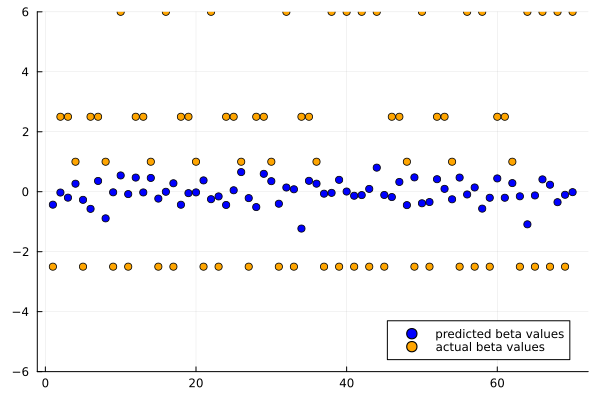

In [42]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 6)

In [37]:
model.pi_star

5000-element Vector{Vector{Vector{Float64}}}:
 [[0.5853619234902727, 0.13777882703369873, 0.21252853635429877, 0.06433071312172985], [0.39398315481101437, 0.18918223906418577, 0.2567356051222372, 0.1600990010025627]]
 [[0.5878514219056591, 0.16176283875355874, 0.17950000893684165, 0.07088573040394054], [0.4062480467873197, 0.21584584334624893, 0.24150550493046274, 0.13640060493596876]]
 [[0.5232470368130876, 0.18045053321526286, 0.2137814238281528, 0.08252100614349682], [0.4047261224352796, 0.20949647054871695, 0.276571995787043, 0.10920541122896042]]
 [[0.5588962069954737, 0.14338712239372725, 0.22067364876940537, 0.07704302184139362], [0.44232367393016475, 0.20611067691603613, 0.2533791482809954, 0.09818650087280371]]
 [[0.5874462637446858, 0.150900350926719, 0.18701927218203274, 0.07463411314656235], [0.3828969345044792, 0.20697320701931982, 0.2864769713037553, 0.12365288717244567]]
 [[0.5330666781804556, 0.1930816032439126, 0.18905223688544992, 0.08479948169018199], [0.430511564463

In [53]:
@show model.gamma_sample[1][1]

(model.gamma_sample[1])[1] = [[[[-1.6283675120759904], [-1.539430908461821], [-1.7491603466142995], [-1.6669836480595015], [-1.6253015658332044], [-1.6026517702685417], [-1.9057016385823222], [-1.7703035814142352], [-1.5717065727342914], [-1.663962057268075], [-1.6011885630973668], [-1.5876829060045587], [-1.722931360851429], [-1.8227130556177755], [-1.4484176691239599], [-1.871299276981484], [-1.7180394267895391], [-1.6263122098952167], [-1.534854298827983], [-1.9440442777409777], [-1.591536400665728], [-1.635134836626329], [-1.6853706539661466], [-1.7010393006320002], [-1.8145717269214379], [-1.8059182579932367], [-1.6481622400082951], [-1.7361036904590936], [-1.8759768488317048], [-1.695788157114304], [-1.6439035787718161], [-1.5365664338344769], [-1.7384368347443364], [-1.7021186270653779], [-1.6032223734455429], [-1.6816111946785324], [-1.8575443142818266], [-1.7068661189460332], [-1.6255808865412413], [-1.7039016691337963], [-1.637129625894719], [-1.4480397676540582], [-1.6453462

1-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[-1.6283675120759904], [-1.539430908461821], [-1.7491603466142995], [-1.6669836480595015], [-1.6253015658332044], [-1.6026517702685417], [-1.9057016385823222], [-1.7703035814142352], [-1.5717065727342914], [-1.663962057268075]  …  [-1.5483257303540365], [-1.673950725678192], [-1.6144636514569164], [-1.7078857932842724], [-1.6791905866327845], [-1.7973238816188892], [-1.778062817970619], [-1.5504032784414785], [-1.6489015234370723], [-1.7248996552001092]], [[-1.840295022584249], [-2.109666642239751], [-1.994926547297952], [-1.9101029025259528], [-1.9942914337446331], [-1.8964079436046377], [-1.9700059768992122], [-1.8198190407894295], [-1.9213119375975083], [-2.0114799160158303]  …  [-1.8344343528562441], [-1.9188758923553153], [-2.112226973623122], [-1.8842536344265157], [-1.9586530066267867], [-1.7767203719646172], [-1.9233441024325986], [-1.7803577202032408], [-1.9316408149924593], [-1.856027043035215]], [[-1.8564136948622336], [-

In [17]:
model.mu_gamma_star[1][1]

1-element Vector{Vector{Vector{Float64}}}:
 [[-1.6828974485397339], [-1.9471861124038696], [-1.8969037532806396], [-0.9690414667129517], [-1.9417850971221924], [-1.2808140516281128], [-2.066089391708374], [-1.876190185546875], [-1.7825480699539185], [-0.8456928133964539]  …  [-1.4661595821380615], [-1.2103866338729858], [-1.5245661735534668], [-1.0676510334014893], [-1.3625144958496094], [-1.6503870487213135], [-1.0556156635284424], [-2.3143599033355713], [-1.8927310705184937], [-2.173685312271118]]

In [84]:
obs.X * -1

2-element Vector{Vector{Matrix{Float64}}}:
 [[-1.0; -1.0; … ; -1.0; -1.0;;], [-1.0 -1.0; -1.0 -1.0; … ; -1.0 -1.0; -1.0 -1.0]]
 [[-1.0; -1.0; … ; -1.0; -1.0;;], [-1.0 -1.0; -1.0 -1.0; … ; -1.0 -1.0; -1.0 -1.0]]